In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine
from sklearn.model_selection import train_test_split
np.random.seed(42)
import scipy.stats as stats
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from datetime import timedelta  



from matplotlib import rcParams
rcParams.update({'figure.autolayout':True})

plt.style.use(["presentation"])

%matplotlib inline

In [10]:


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, mean_squared_error, confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import svm


In [11]:
test=pd.read_pickle('./assets/test_step1')

In [12]:
train=pd.read_pickle('./assets/train_step1')

In [13]:
pred=pd.read_pickle('./assets/prediction_step1')

In [14]:
NOAA=pd.read_pickle('./assets/NOAA')

# A. More feature engineering

In [15]:
# Found a paper, https://parasitesandvectors.biomedcentral.com/articles/10.1186/1756-3305-6-129,
# that says that length of day for the last 30 days and the wind speed for the past 20 days
# are both important to predicting Culex pipiens.  So let's get that weather data.


In [8]:
test['day']=test['Date'].map(lambda x: x.dayofyear)
train['day']=train['Date'].map(lambda x: x.dayofyear)
pred['day']=pred['Date'].map(lambda x: x.dayofyear)


In [9]:
test['day2']=test['day']**2
train['day2']=train['day']**2
pred['day2']=pred['day']**2

In [10]:
def convert(x):
    if x[-2:]=='60':
        x=re.sub('60$', '59', x)
    x=pd.to_datetime(x, format='%H%M')
    return x



In [11]:
NOAA['Sunset']=NOAA['Sunset'].map(convert)
NOAA['Sunrise']=NOAA['Sunrise'].map(convert)

In [12]:
NOAA['Daylength']=(NOAA['Sunset']-NOAA['Sunrise']).astype('timedelta64[m]')

In [13]:
def measure_recent_days(A):
    return NOAA.loc[(NOAA['Date']>(A-timedelta(days=7)))&(NOAA['Date']<=A)]['Daylength'].mean()

In [14]:
train['recent_day_length']=train['Date'].map(measure_recent_days)

In [15]:
test['recent_day_length']=test['Date'].map(measure_recent_days)

In [16]:
pred['recent_day_length']=pred['Date'].map(measure_recent_days)

In [17]:
# Create a quadratic term for day length

train['day_length_2']=train['recent_day_length']**2
test['day_length_2']=test['recent_day_length']**2
pred['day_length_2']=pred['recent_day_length']**2


In [18]:
new_vals = []

for i, x in enumerate(NOAA['AvgSpeed']):
    if x == 'M':
        new_vals.append(NOAA['AvgSpeed'].loc[i+1])
    else:
        new_vals.append(x)
        
NOAA['AvgSpeed'] = new_vals
NOAA['AvgSpeed'] = NOAA['AvgSpeed'].astype(float)

In [19]:
def measure_recent_wind(A):
    return NOAA.loc[(NOAA['Date']>(A-timedelta(days=20)))&(NOAA['Date']<=A)]['AvgSpeed'].mean()

In [20]:
train['recent_wind']=train['Date'].map(measure_recent_wind)

In [21]:
test['recent_wind']=test['Date'].map(measure_recent_wind)

In [22]:
pred['recent_wind']=pred['Date'].map(measure_recent_wind)

In [23]:
# The east-west axis might be relevant due to the presence of Lake Michigan.

In [184]:
train['north_south']=train['Location'].map(lambda x: x[0])
train['north_south2']=train['north_south']**2

In [185]:
test['north_south']=test['Location'].map(lambda x: x[0])
test['north_south2']=test['north_south']**2

In [186]:
pred['north_south']=pred['Location'].map(lambda x: x[0])
pred['north_south2']=pred['north_south']**2

In [187]:
train['east_west']=train['Location'].map(lambda x: x[1])
train['east_west2']=train['east_west']**2

In [188]:
test['east_west']=test['Location'].map(lambda x: x[1])
test['east_west2']=test['east_west']**2

In [189]:
pred['east_west']=pred['Location'].map(lambda x: x[1])
pred['east_west2']=pred['east_west']**2

In [193]:
train.to_pickle('./assets/train_step2')

In [194]:
test.to_pickle('./assets/test_step2')

In [195]:
pred.to_pickle('./assets/pred_step2')

## A.1 A little EDA on the new features

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


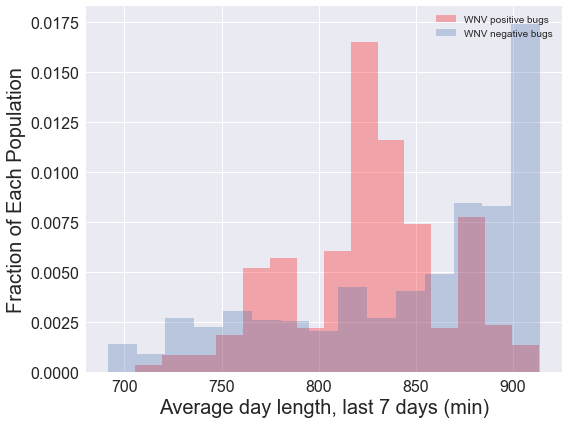

In [196]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

train.loc[train['WnvPresent']==1]['recent_day_length'].hist(bins=15, alpha=.3, density=True, label = 'WNV positive bugs', color='red')
train.loc[train['WnvPresent']==0]['recent_day_length'].hist(bins=15, alpha=.3, density=True, label = 'WNV negative bugs',)
plt.legend(loc='upper right')
ax.set_xlabel('Average day length, last 7 days (min)')
ax.set_ylabel('Fraction of Each Population')

plt.savefig("./EDA1.png")

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


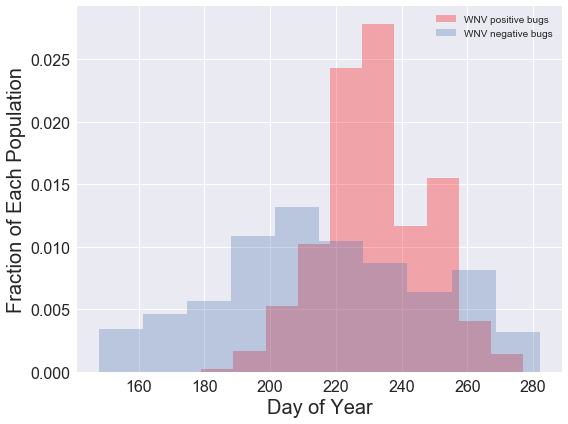

In [197]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

train.loc[train['WnvPresent']==1]['day'].hist( alpha=.3, density=True, label = 'WNV positive bugs', color='red')
train.loc[train['WnvPresent']==0]['day'].hist(alpha=.3, density=True, label = 'WNV negative bugs',)
plt.legend(loc='upper right')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Fraction of Each Population')

plt.savefig("./EDA2.png")

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


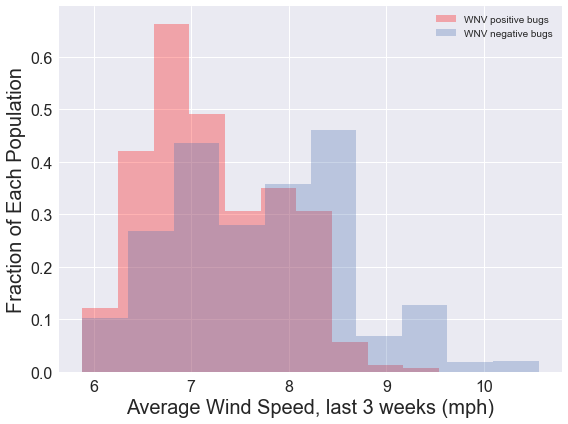

In [198]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

train.loc[train['WnvPresent']==1]['recent_wind'].hist( alpha=.3, density=True, label = 'WNV positive bugs', color='red')
train.loc[train['WnvPresent']==0]['recent_wind'].hist( alpha=.3, density=True, label = 'WNV negative bugs',)
plt.legend(loc='upper right')
ax.set_xlabel('Average Wind Speed, last 3 weeks (mph)')
ax.set_ylabel('Fraction of Each Population')

plt.savefig("./timing.png")

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


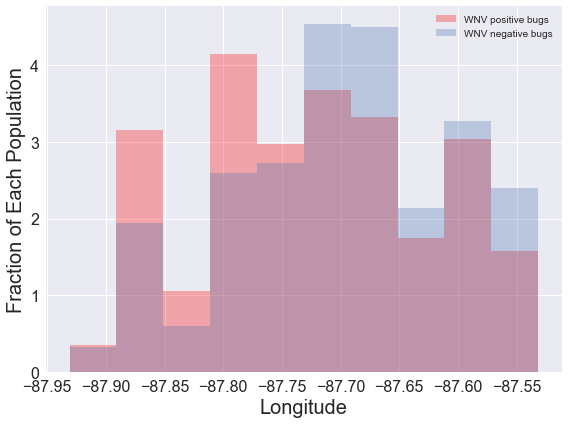

In [199]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

train.loc[train['WnvPresent']==1]['east_west'].hist( alpha=.3, density=True, label = 'WNV positive bugs', color='red')
train.loc[train['WnvPresent']==0]['east_west'].hist( alpha=.3, density=True, label = 'WNV negative bugs',)
plt.legend(loc='upper right')
ax.set_xlabel('Longitude')
ax.set_ylabel('Fraction of Each Population')

plt.savefig("./timing.png")

# B. Bootstrap the WNV-positive data to generate balanced classes for training

In [200]:
train_positive=train.loc[train['WnvPresent']==1]

In [201]:
train_negative=train.loc[train['WnvPresent']==0]

In [202]:
train_positive.shape

(429, 63)

In [203]:
# We have 7,975 samples that are negative.  We need 7,546 extra samples of positive data
# to balance the classes

train_negative.shape[0]-train_positive.shape[0]

7546

In [204]:
# Sample the negative data to get 7,546 extra samples of positive data

train_positive_extra=train_positive.sample(n=7546, replace=True)

In [205]:
# Concat the positive, negative, and extra negative rows

train_oversample=pd.concat([train_positive, train_negative, train_positive_extra])

In [206]:
# Shuffle the rows

train_oversample=train_oversample.sample(frac=1)

# C. Generate feature matrix and target vector

In [207]:
y_train_o=train_oversample['WnvPresent'].values
y_train=train['WnvPresent'].values
y_test=test['WnvPresent'].values

In [208]:
# Cutting out the day and day^2 features, because probably too similar to the 
# day length features.  Also cutting out some of the street features that were
# less significant.

features= ['MIX',
       'PIPIENS', 'RESTUANS', 'recent_temps', 'min_recent_temps',
       'recent_precip', 'dist_to_standing_water', 'dist_to_spray',  
           'recent_day_length', 'day_length_2', 'recent_wind', 'east_west', 'north_south',
           'east_west2', 'north_south2',
       ' W OHARE AIRPORT', ' N OAK PARK AVE', ' S DOTY AVE',
       ' N MILWAUKEE AVE', ' S KOSTNER AVE']

In [209]:
# o means a feature matrix from an oversampled set


X_train_o=train_oversample[features]
X_train=train[features]
X_test=test[features]
X_pred=pred[features]


# D. Try a Random Forest

In [114]:
rf=RandomForestClassifier()

## D.1., I got better results using the balanced class weights hyperparameter, and not using oversampled training observations.

In [150]:
hyperparameters={
                'n_estimators': [150],
                'max_depth': [50, 100, 150],
                'min_samples_split': [100, 125, 150],
                'class_weight': ['balanced']
}
                
rfgrid = GridSearchCV(rf, hyperparameters, cv=3, scoring='roc_auc')

In [151]:
rfgrid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [150], 'max_depth': [50, 100, 150], 'min_samples_split': [100, 125, 150], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [152]:
rfgrid.best_params_

{'class_weight': 'balanced',
 'max_depth': 150,
 'min_samples_split': 125,
 'n_estimators': 150}

In [153]:
rfgrid.score(X_test, y_test)

0.8401867030965392

In [154]:
rfgrid.score(X_train, y_train)

0.9155567734251119

In [155]:
roc_auc_score(y_test, rfgrid.predict(X_test))

0.7549842689186952

In [156]:
roc_auc_score(y_train, rfgrid.predict(X_train))

0.8282806848324089

## D.2 See what happens when you change the classification threshold

In [157]:
def threshold_predict(model, threshold, inputvals):
    return [1 if item[1]>threshold else 0 for item in model.predict_proba(inputvals)]

In [158]:
def score_model (model, modelname, threshold, Xvals, yvals):
    
    y_predict=threshold_predict(model, threshold, Xvals)
    
    conf=confusion_matrix(yvals, y_predict)
    
    print ("False Positive Rate", conf[0][1]/(conf[0][1]+conf[0][0]))
    
    print ("False Negative Rate", conf[1][0]/(conf[1][0]+conf[1][1]))
    
    print ("Accuracy", (conf[1][1]+conf[0][0])/(conf[1][1]+conf[0][0]+conf[1][0]+conf[0][1]))
    

In [159]:
score_model(rfgrid, "Random Forest", .1, X_test, y_test)

False Positive Rate 0.6313131313131313
False Negative Rate 0.03278688524590164
Accuracy 0.4034253092293054


In [160]:
score_model(rfgrid, "Random Forest", .2, X_test, y_test)

False Positive Rate 0.4914141414141414
False Negative Rate 0.04918032786885246
Accuracy 0.5342530922930543


In [161]:
score_model(rfgrid, "Random Forest", .3, X_test, y_test)

False Positive Rate 0.36717171717171715
False Negative Rate 0.09836065573770492
Accuracy 0.648430066603235


In [162]:
score_model(rfgrid, "Random Forest", .4, X_test, y_test)

False Positive Rate 0.2833333333333333
False Negative Rate 0.20491803278688525
Accuracy 0.7212178877259753


In [163]:
score_model(rfgrid, "Random Forest", .5, X_test, y_test)

False Positive Rate 0.19494949494949496
False Negative Rate 0.29508196721311475
Accuracy 0.7992388201712655


## D.3. Find out what the Random Forest Model was focusing on

In [164]:
importance=rfgrid.best_estimator_.feature_importances_

In [165]:
importance

array([0.0122151 , 0.01740513, 0.03223286, 0.10935201, 0.07144889,
       0.0506097 , 0.03821476, 0.04253734, 0.18249562, 0.20902321,
       0.08510879, 0.07352794, 0.05613351, 0.00246576, 0.00285765,
       0.00577519, 0.00264401, 0.00595254])

In [166]:
explanation=pd.DataFrame({'features':features, 'importance':importance})

In [167]:
explanation.sort_values(by='importance', ascending=True)

,features,importance
13,W OHARE AIRPORT,0.002466
16,N MILWAUKEE AVE,0.002644
14,N OAK PARK AVE,0.002858
15,S DOTY AVE,0.005775
17,S KOSTNER AVE,0.005953
0,MIX,0.012215
1,PIPIENS,0.017405
2,RESTUANS,0.032233
6,dist_to_standing_water,0.038215
7,dist_to_spray,0.042537


In [168]:

print(train.loc[train['WnvPresent']==1]['dist_to_spray'].mean())
print(train.loc[train['WnvPresent']==0]['dist_to_spray'].mean())


2.0733572212885703
2.323630532478759


In [169]:
print(train.loc[train['WnvPresent']==1]['dist_to_standing_water'].mean())
print(train.loc[train['WnvPresent']==0]['dist_to_standing_water'].mean())


1.1704312191125084
0.9838460696166562


# E. Support Vector Machine generating AUC score of .73, slightly better than Random Forest.  Also showing less overfitting than Random Forest.

In [170]:
pipeline3 = Pipeline([
    
    ('ss', StandardScaler()),
    ('sv', svm.SVC())
])



In [171]:
hyperparameters={
            'sv__C':[.1] ,   
            'sv__gamma': [.1],
            'sv__class_weight': ['balanced'],
            'sv__probability': [True]
}
                
svcgrid = GridSearchCV(pipeline3, hyperparameters, cv=3, scoring='roc_auc')

In [172]:
# I didn't use the oversampled data because SVC has an alternate method of setting balanced
# class weightings, instead of using oversampled data.

svcgrid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sv', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'sv__C': array([1.e-04, 1.e-01, 1.e+02]), 'sv__gamma': array([1.e-04, 1.e-01, 1.e+02]), 'sv__class_weight': ['balanced'], 'sv__probability': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [173]:
svcgrid.best_params_

{'sv__C': 0.1,
 'sv__class_weight': 'balanced',
 'sv__gamma': 0.1,
 'sv__probability': True}

In [174]:
svcgrid.score(X_train, y_train)

0.8500423087883904

In [175]:
svcgrid.score(X_test, y_test)

0.7999234144725947

In [176]:
roc_auc_score(y_test, svcgrid.predict(X_test))

0.7364505712866368

In [177]:
roc_auc_score(y_train, svcgrid.predict(X_train))

0.7794437746161884

In [178]:
score_model(svcgrid, "SVC", .1, X_test, y_test)

False Positive Rate 0.6313131313131313
False Negative Rate 0.03278688524590164
Accuracy 0.4034253092293054


In [179]:
score_model(svcgrid, "SVC", .2, X_test, y_test)

False Positive Rate 0.4914141414141414
False Negative Rate 0.04918032786885246
Accuracy 0.5342530922930543


In [180]:
score_model(svcgrid, "SVC", .3, X_test, y_test)

False Positive Rate 0.36717171717171715
False Negative Rate 0.09836065573770492
Accuracy 0.648430066603235


In [181]:
score_model(svcgrid, "SVC", .4, X_test, y_test)

False Positive Rate 0.2833333333333333
False Negative Rate 0.20491803278688525
Accuracy 0.7212178877259753


In [182]:
score_model(svcgrid, "SVC", .5, X_test, y_test)

False Positive Rate 0.19494949494949496
False Negative Rate 0.29508196721311475
Accuracy 0.7992388201712655


# F. Logistic Regression has comparable results to SVC.  Very little sign of overfitting.

In [210]:
ss=StandardScaler()

In [211]:
X_train_o=ss.fit_transform(X_train_o)

In [212]:
X_test=ss.transform(X_test)

In [213]:
lm=LogisticRegression(C=10, penalty='l1')

In [214]:
# Using oversampled training data

lm.fit(X_train_o, y_train_o)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [215]:
roc_auc_score(y_test, lm.predict(X_test))

0.7268339128994867

In [216]:
roc_auc_score(y_train_o, lm.predict(X_train_o))

0.7431974921630095

In [217]:
score_model(lm, "Logistic Regression", .1, X_test, y_test)

False Positive Rate 0.7358585858585859
False Negative Rate 0.0
Accuracy 0.30685061845861084


In [218]:
score_model(lm, "Logistic Regression", .2, X_test, y_test)

False Positive Rate 0.6106060606060606
False Negative Rate 0.02459016393442623
Accuracy 0.4234062797335871


In [219]:
score_model(lm, "Logistic Regression", .3, X_test, y_test)

False Positive Rate 0.5313131313131313
False Negative Rate 0.07377049180327869
Accuracy 0.49524262607040914


In [220]:
score_model(lm, "Logistic Regression", .4, X_test, y_test)

False Positive Rate 0.4414141414141414
False Negative Rate 0.12295081967213115
Accuracy 0.577069457659372


In [221]:
score_model(lm, "Logistic Regression", .5, X_test, y_test)

False Positive Rate 0.3414141414141414
False Negative Rate 0.20491803278688525
Accuracy 0.6665080875356802


In [222]:
score_model(lm, "Logistic Regression", .6, X_test, y_test)

False Positive Rate 0.24292929292929294
False Negative Rate 0.3114754098360656
Accuracy 0.7530922930542341


In [223]:
score_model(lm, "Logistic Regression", .7, X_test, y_test)

False Positive Rate 0.14393939393939395
False Negative Rate 0.4918032786885246
Accuracy 0.8358705994291151


In [224]:
score_model(lm, "Logistic Regression", .8, X_test, y_test)

False Positive Rate 0.03737373737373737
False Negative Rate 0.7950819672131147
Accuracy 0.9186489058039962


In [225]:
score_model(lm, "Logistic Regression", .9, X_test, y_test)

False Positive Rate 0.005050505050505051
False Negative Rate 0.9344262295081968
Accuracy 0.9410085632730733


# G. What is the regression looking at?

In [226]:
coefs=lm.coef_

In [227]:
coefs=coefs.ravel()

In [228]:
explanation=pd.DataFrame({'features':features, 'coefs':coefs})

In [229]:
explanation.sort_values(by='coefs')

,coefs,features
9,-30.045362,day_length_2
12,-0.515984,north_south
6,-0.122009,dist_to_standing_water
5,-0.079327,recent_precip
4,-0.059005,min_recent_temps
7,-0.055922,dist_to_spray
11,0.000000,east_west
10,0.079250,recent_wind
15,0.120906,W OHARE AIRPORT
17,0.127091,S DOTY AVE
